In [20]:
pip install pandas matplotlib seaborn nltk textblob wordcloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


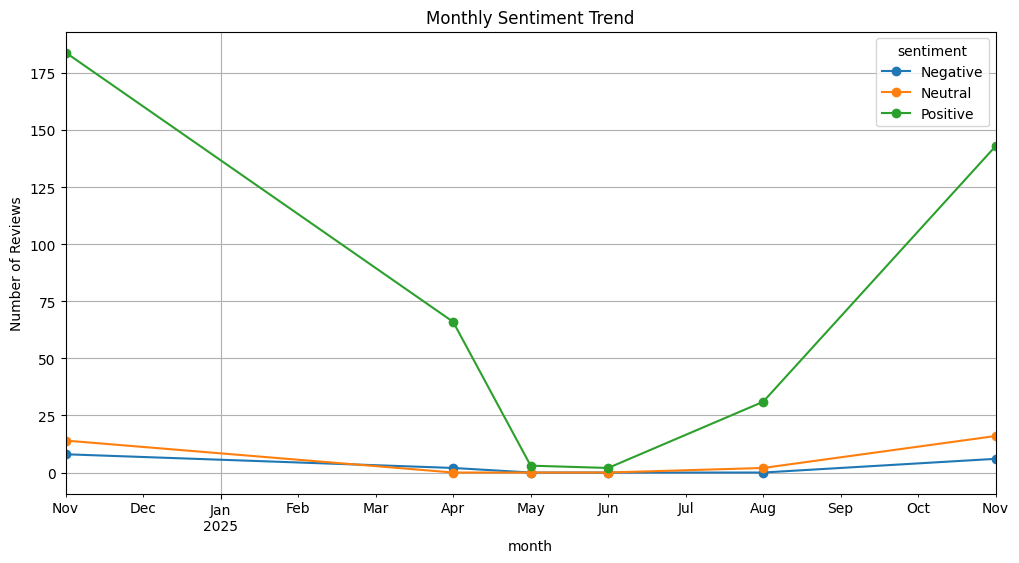

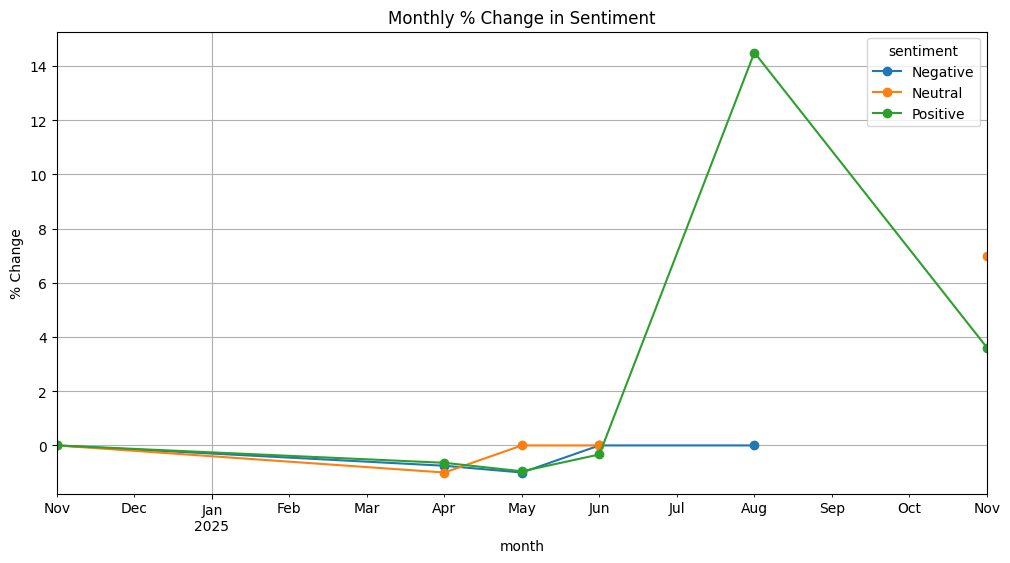

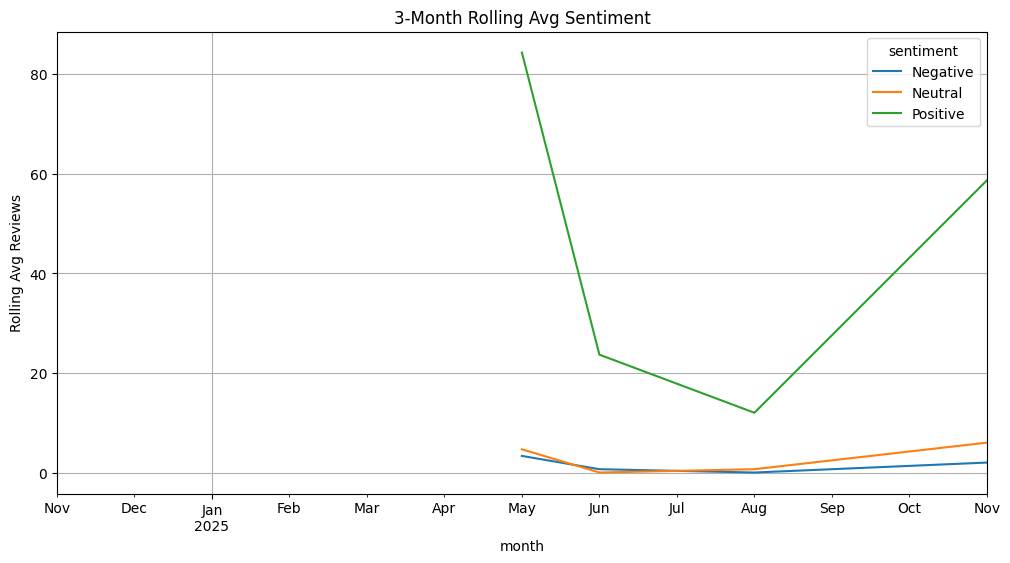

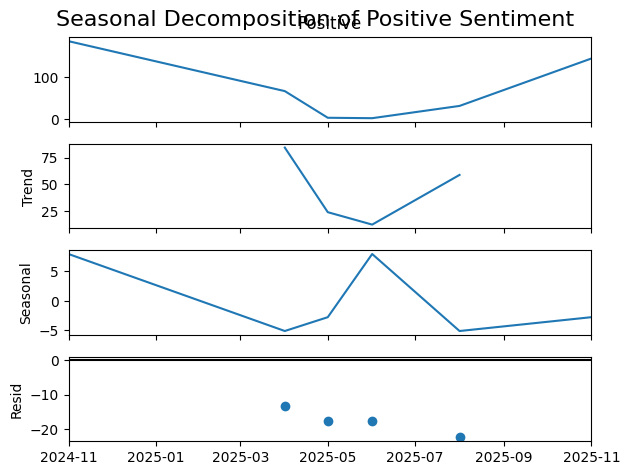

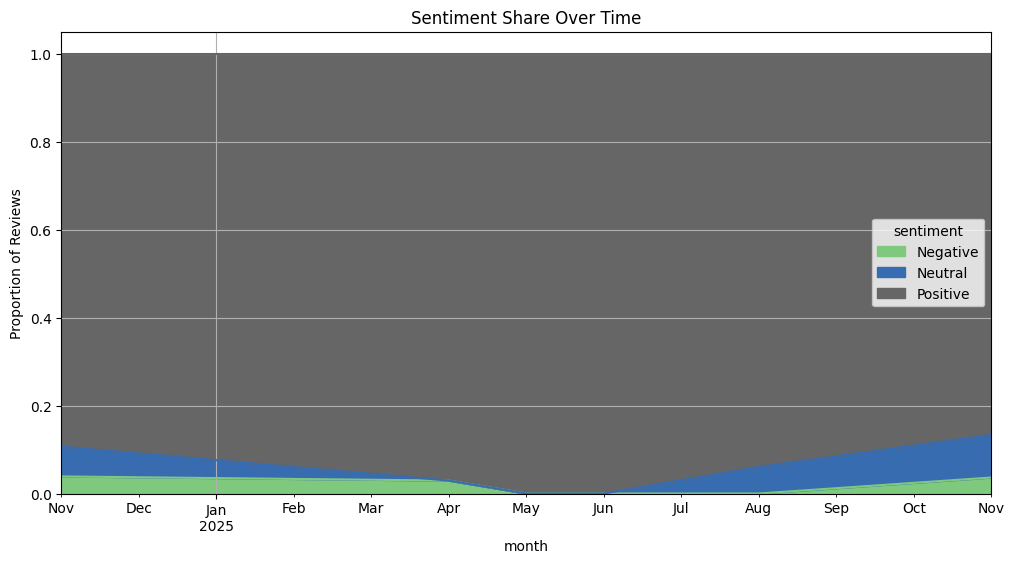


Outlier Months with High Negative Sentiment:
 Empty DataFrame
Columns: [Negative, Neutral, Positive]
Index: []


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsau4_5co/xpvmeqgd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsau4_5co/e39x5nbf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68213', 'data', 'file=/tmp/tmpsau4_5co/xpvmeqgd.json', 'init=/tmp/tmpsau4_5co/e39x5nbf.json', 'output', 'file=/tmp/tmpsau4_5co/prophet_modelik91_v8g/prophet_model-20250415135504.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:55:04 - cmdstanpy - INFO - Chain [1] start processing
IN

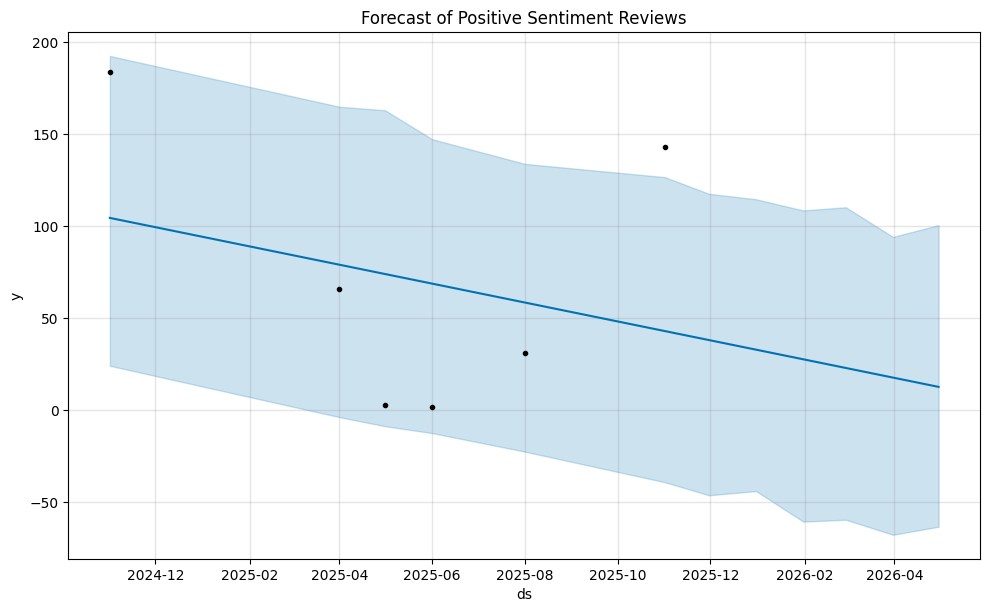


As of November 2025, most reviews were 'Positive' and least were 'Negative'.


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
from scipy.stats import zscore
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
import nltk
nltk.download('punkt')

# Load dataset
file_path = 'kochi_edutech_reviews_new.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Drop empty reviews
df.dropna(subset=['review'], inplace=True)
df = df[df['review'].str.strip() != '']

# Sentiment Analysis
df['polarity'] = df['review'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df['subjectivity'] = df['review'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

def get_sentiment(score):
    if score > 0.1:
        return 'Positive'
    elif score < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['polarity'].apply(get_sentiment)

# Convert date column
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df.dropna(subset=['date'], inplace=True)
    df['month'] = df['date'].dt.to_period('M')

    # Monthly sentiment count
    monthly_sentiment = df.groupby(['month', 'sentiment']).size().unstack().fillna(0)

    # Plot raw sentiment trend
    monthly_sentiment.plot(kind='line', figsize=(12, 6), marker='o', title='Monthly Sentiment Trend')
    plt.ylabel('Number of Reviews')
    plt.grid(True)
    plt.show()

    # Monthly percentage change
    monthly_sentiment.pct_change().fillna(0).plot(figsize=(12,6), marker='o', title='Monthly % Change in Sentiment')
    plt.ylabel('% Change')
    plt.grid(True)
    plt.show()

    # Rolling average
    monthly_sentiment.rolling(window=3).mean().plot(figsize=(12,6), title='3-Month Rolling Avg Sentiment')
    plt.ylabel('Rolling Avg Reviews')
    plt.grid(True)
    plt.show()

    # Decomposition (for one sentiment)
    ts = monthly_sentiment['Positive']
    ts.index = ts.index.to_timestamp()
    result = seasonal_decompose(ts, model='additive', period=3)
    result.plot()
    plt.suptitle('Seasonal Decomposition of Positive Sentiment', fontsize=16)
    plt.show()

    # Sentiment share
    sentiment_share = monthly_sentiment.div(monthly_sentiment.sum(axis=1), axis=0)
    sentiment_share.plot(kind='area', stacked=True, figsize=(12, 6), colormap='Accent', title='Sentiment Share Over Time')
    plt.ylabel('Proportion of Reviews')
    plt.grid(True)
    plt.show()

    # Outlier detection
    z_scores = zscore(monthly_sentiment['Negative'])
    outliers = monthly_sentiment[z_scores > 2]
    print("\nOutlier Months with High Negative Sentiment:\n", outliers)

    # Forecasting with Prophet
    prophet_df = monthly_sentiment['Positive'].reset_index()
    prophet_df.columns = ['ds', 'y']
    prophet_df['ds'] = pd.to_datetime(prophet_df['ds'].astype(str))

    model = Prophet()
    model.fit(prophet_df)

    future = model.make_future_dataframe(periods=6, freq='M')
    forecast = model.predict(future)

    model.plot(forecast)
    plt.title("Forecast of Positive Sentiment Reviews")
    plt.show()

    # Automated Insight
    latest_month = monthly_sentiment.index.max()
    latest = monthly_sentiment.loc[latest_month]
    print(f"\nAs of {latest_month.strftime('%B %Y')}, most reviews were '{latest.idxmax()}' and least were '{latest.idxmin()}'.")
